In [20]:
import pandas as pd
import numpy as np

In [21]:
#Membership status
years = ['2014', '2015', '2016', '2017','2018']
memberStatus = ['bronze', 'silver', 'gold', 'inactive']

In [22]:
memberYears = np.random.choice(years, 1000,
              p = [0.1, 0.1, 0.15, 0.30, 0.35])
memberStats = np.random.choice(memberStatus, 1000,
              p = [0.5, 0.3, 0.1, 0.1])
yearJoined = pd.DataFrame({'yearJoined':memberYears,
                           'memberStats':memberStats})
yearJoined.head()

,yearJoined,memberStats
0,2017,bronze
1,2014,silver
2,2015,gold
3,2017,silver
4,2014,bronze


In [23]:
NUM_OF_EMAILS_SENT_WEEKLY = 3

#we define several fxns for diff patterns
def never_opens(period_rng):
    return []

def constant_open_rate(period_rng):
    n, p = NUM_OF_EMAILS_SENT_WEEKLY, np.random.uniform(0,1)
    num_opened = np.random.binomial(n, p, len(period_rng))
    return num_opened

def increasing_open_rate(period_rng):
    return open_rate_with_factor_change(period_rng, np.random.uniform(1.01, 1.30))

def decreasing_open_rate(period_rng):
    return open_rate_with_factor_change(period_rng, np.random.uniform(0.5, 0.99))

def open_rate_with_factor_change(period_rng, fac):
    if len(period_rng) < 1:
        return[]
    times = np.random.randint(0, len(period_rng),
                             int(0.1*len(period_rng)))
    num_opened = np.zeros(len(period_rng))
    for prd in range(0, len(period_rng), 2):
        try:
            n, p = NUM_OF_EMAILS_SENT_WEEKLY, np.random.uniform(0,1)
            num_opened[prd:(prd + 2)] = np.random.binomial(n, p, 2)
            p = max(min(1, p *fac), 0)
        except:
            num_opened[prd] = np.random.binomial(n, p, 1)
    for t in range(len(times)):
        num_opened[times[t]] = 0
    return num_opened    

In [27]:
#donation behaviour
def produce_donations(period_rng, member_behavior, num_emails, use_id, member_join_year):
    donation_amounts = np.array([0, 25, 50, 75, 100, 250, 500, 1000, 1500, 2000])
    member_has = np.random.choice(donation_amounts)
    
    email_fraction = num_emails / (NUM_OF_EMAILS_SENT_WEEKLY * len(period_rng))
    
    member_gives = member_has * email_fraction
    
    member_gives_idx = np.where(member_gives >= donation_amounts)[0][-1]
    member_gives_idx = max(min(member_gives_idx, len(donation_amounts) - 2), 1)
    
    num_times_gave = np.random.poisson(2) * (2018 - member_join_year)
    times = np.random.randint(0, len(period_rng), num_times_gave)
    dons = pd.DataFrame({'member' : [], 'amount' : [], 'timestamp': []})
    
    for n in range(num_times_gave):
        donation = donation_amounts[member_gives_idx + np.random.binomial(1, .3)]
        ts = str(period_rng[times[n]].start_time + random_weekly_time_delta())
        dons = dons.append(pd.DataFrame({'member' : [use_id], 'amount' : [donation], 'timestamp': [ts]}))

    if dons.shape[0] > 0:
        dons = dons[dons.amount != 0]
# we don't report zero donation events as this would not
# be recorded in a real world database


In [28]:
def random_weekly_time_delta():
    days_of_week = [d for d in range(7)]
    hours_of_day = [h for h in range(11, 23)]
    minute_of_hour = [m for m in range(60)]
    second_of_minute = [s for s in range(60)]
    
    return pd.Timedelta(str(np.random.choice(days_of_week)) + " days" ) + pd.Timedelta(
        str(np.random.choice(hours_of_day))+ " hours" ) + pd.Timedelta(
        str(np.random.choice(minute_of_hour)) + " minutes") + pd.Timedelta(
        str(np.random.choice(second_of_minute)) + " seconds")

In [33]:
behaviors = [never_opens, constant_open_rate, increasing_open_rate, decreasing_open_rate]

member_behaviors = np.random.choice(behaviors, 1000,[0.2, 0.5, 0.1, 0.2])
rng = pd.period_range('2015-02-14', '2018-06-01', freq = 'W')

emails = pd.concat([emails, pd.DataFrame({'member': [idx] * len(info),
                   'week': [str(r.start_time) for r in member_rng],
                   'emailsOpened': info})], ignore_index=True)
donations = pd.concat([donations, produce_donations(member_rng, member_behaviors[idx], sum(info), idx, join_date.year)], 
                      ignore_index=True)
for idx in range(yearJoined.shape[0]):
    ## randomly generate the date when a member would have joined
    join_date = pd.Timestamp(yearJoined.iloc[idx].yearJoined) + pd.Timedelta(str(np.random.randint(0, 365)) +' days')
    join_date = min(join_date, pd.Timestamp('2018-06-01'))

    # Convert join_date to a Period
    join_date_period = join_date.to_period('W')

    # member should not have action timestamps before joining
    member_rng = rng[rng > join_date_period.to_timestamp()]
    if len(member_rng) < 1:
        continue
    info = member_behaviors[idx](member_rng)
    
    if len(info) == len(member_rng):
        emails = emails.append(pd.DataFrame({'member': [idx] * len(info),
                 'week': [str(r.start_time) for r in member_rng],
                 'emailsOpened': info}))
        donations = donations.append(
            produce_donations(member_rng, member_behaviors[idx], sum(info), idx, join_date.year))

ValueError: All arrays must be of the same length

ValueError: zero-size array to reduction operation fmin which has no identity

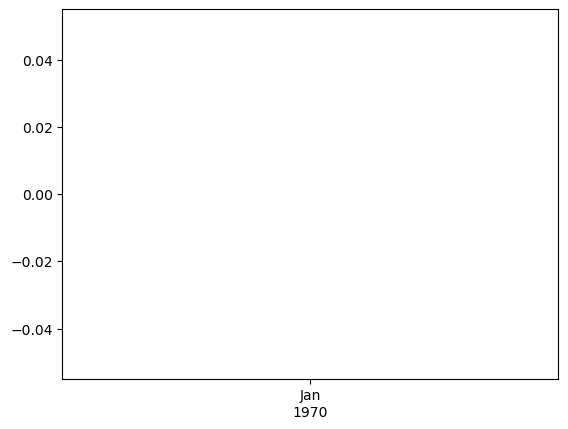

In [31]:
donations.set_index(pd.to_datetime(donations.timestamp), inplace = True)
donations.sort_index(inplace = True)
donations.groupby(pd.Grouper(freq='M')).amount.sum().plot()